In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

%matplotlib inline

In [3]:
df = pd.read_excel('/Users/wanmeng/Desktop/data文件/relay-foods.xlsx',sheet_name='Purchase Data - Full Study')
df.head(5)

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


<font color=black size=4 face=雅黑>**基于OrderDate来对订单按月分类**</font>

In [4]:
df['OrderPeriod'] = df.OrderDate.apply(lambda x: x.strftime('%Y-%m'))
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,2009-02
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,2009-02
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,2009-02


<font color=black size=4 face=雅黑>**根据首次购买日期决定用户的群组**</font>

In [6]:
df.set_index('UserId', inplace=True)
df.head()

,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod
UserId,,,,,,,
47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01
47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01
47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02
47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02
47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02


In [7]:
df['CohortGroup'] = df.groupby(level=0)['OrderDate'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)

In [8]:
df.head()

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02,2009-01


<font color=black size=4 face=雅黑>**根据CohortGroup 以及 OrderPeriod进行数据汇总**</font>

In [10]:
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

# 不同用户数，订单数以及总的收入
cohorts = grouped.agg({'UserId': pd.Series.nunique,
                       'OrderId': pd.Series.nunique,
                       'TotalCharges': np.sum})

cohorts.rename(columns={'UserId': 'TotalUsers',
                        'OrderId': 'TotalOrders'}, inplace=True)
cohorts.head()

TotalUsers  TotalOrders  TotalCharges
CohortGroup OrderPeriod                                       
2009-01     2009-01              22           30      1850.255
            2009-02               8           25      1351.065
            2009-03              10           26      1357.360
            2009-04               9           28      1604.500
            2009-05              10           26      1575.625

<font color=black size=4 face=雅黑>**每个CohortGroup在每个CohortPeriod的购买行为**</font>

研究每个CohortGroup在首次购买后的每个CohortPeriod的购买行为，ohortPeriod = 1 代表第一个月，CohortPeriod = 2代表第二个月

In [11]:
def cohort_period(df):
  
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  TotalOrders  TotalCharges  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01              22           30      1850.255             1
            2009-02               8           25      1351.065             2
            2009-03              10           26      1357.360             3
            2009-04               9           28      1604.500             4
            2009-05              10           26      1575.625             5

<font color=black size=4 face=雅黑>**按照CohortGroup计算留存留存**</font>

In [12]:
# reindex 
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: TotalUsers, dtype: int64

In [13]:
cohorts['TotalUsers'].head(10)

CohortGroup  CohortPeriod
2009-01      1               22
             2                8
             3               10
             4                9
             5               10
             6                8
             7                8
             8                7
             9                7
             10               7
Name: TotalUsers, dtype: int64

In [14]:
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,...,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,
1,22.0,15.0,13.0,39.0,50.0,...,130.0,65.0,95.0,100.0,24.0
2,8.0,3.0,4.0,13.0,13.0,...,32.0,17.0,50.0,19.0,NaN
3,10.0,5.0,5.0,10.0,12.0,...,26.0,18.0,26.0,NaN,NaN
4,9.0,1.0,4.0,13.0,5.0,...,29.0,7.0,NaN,NaN,NaN
5,10.0,4.0,1.0,6.0,4.0,...,13.0,NaN,NaN,NaN,NaN


In [15]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,...,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,...,1.000000,1.000000,1.000000,1.00,1.0
2,0.363636,0.200000,0.307692,0.333333,0.26,...,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,...,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,...,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,...,0.100000,NaN,NaN,NaN,NaN
6,0.363636,0.266667,0.153846,0.179487,0.12,...,NaN,NaN,NaN,NaN,NaN
7,0.363636,0.266667,0.153846,0.102564,0.06,...,NaN,NaN,NaN,NaN,NaN
8,0.318182,0.333333,0.230769,0.153846,0.10,...,NaN,NaN,NaN,NaN,NaN
9,0.318182,0.333333,0.153846,0.051282,0.10,...,NaN,NaN,NaN,NaN,NaN


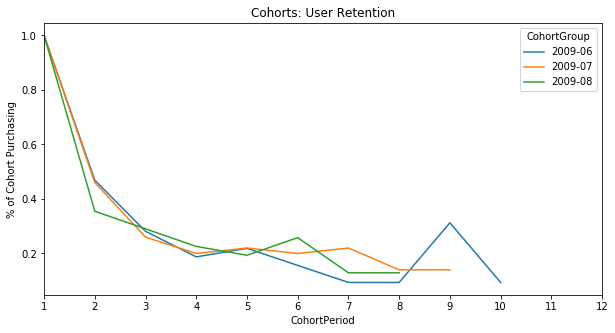

In [16]:
user_retention[['2009-06', '2009-07', '2009-08']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

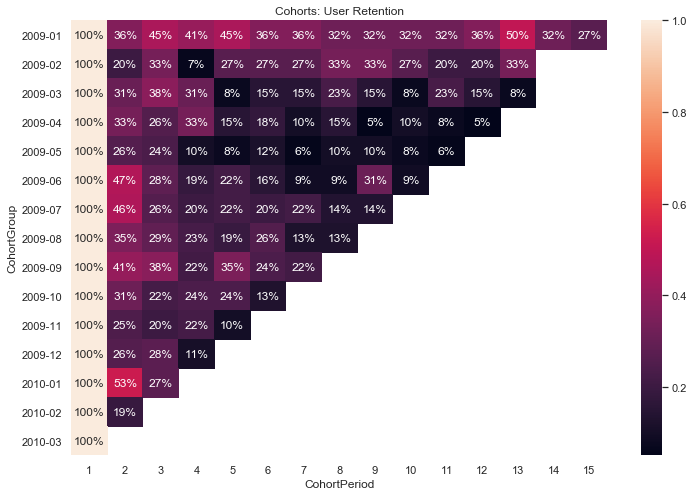

In [17]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T,  mask=user_retention.T.isnull(),annot=True, fmt='.0%');